In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline

import pingouin as pg

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import KBinsDiscretizer

from causalnex.structure import StructureModel
import networkx as nx

# PyTorchのDAGを使う
from causalnex.structure.pytorch import from_pandas

from causalnex.structure.pytorch.core import NotearsMLP

from causalnex.network import BayesianNetwork
from causalnex.discretiser import Discretiser
from causalnex.evaluation import classification_report
from causalnex.evaluation import roc_auc
from causalnex.inference import InferenceEngine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier

import optuna

# original package
# from lab_tools.pickle_manage import *

import warnings
warnings.simplefilter('ignore')

# データ読み込みから前処理

In [2]:
df = pd.read_excel('../data/231010-20_AI用qPCRデータ.xlsx', index_col=0, header=1)
df = df.dropna()
df = df.reset_index(drop=True)
df

,glk,agp,yihX,pgm,ptsG,malx,crr,galM,yihR,yeaD,...,tpiA,gapA,pgk,gpmA,ytjc,gpmM,eno,pykF,pykA,ppsA
0,0.000004,2.982088e-05,0.000004,1.512045e-05,0.000015,9.403729e-07,0.000122,0.000015,4.792578e-07,0.000007,...,0.000008,0.000121,1.193258e-07,0.000119,0.000004,0.000008,0.000015,0.000030,0.000015,0.000030
1,0.000008,3.062644e-05,0.000016,2.940716e-08,0.000015,3.847846e-06,0.000124,0.000015,3.848767e-06,0.000015,...,0.000015,0.000123,2.377373e-07,0.000123,0.000008,0.000016,0.000031,0.000061,0.000031,0.000061
2,0.000008,7.608227e-06,0.000016,1.396326e-08,0.000031,9.615077e-07,0.000245,0.000015,4.864569e-07,0.000031,...,0.000015,0.000122,9.666787e-07,0.000122,0.000008,0.000016,0.000062,0.000062,0.000031,0.000062
3,0.000004,1.513944e-05,0.000015,1.225795e-07,0.000015,4.807837e-07,0.000124,0.000015,1.207673e-07,0.000008,...,0.000015,0.000061,2.410427e-07,0.000061,0.000004,0.000008,0.000031,0.000062,0.000031,0.000062
4,0.000008,4.768491e-07,0.000031,6.105349e-08,0.000031,9.593193e-07,0.000124,0.000015,2.428970e-07,0.000016,...,0.000016,0.000124,4.795912e-07,0.000124,0.000008,0.000008,0.000031,0.000062,0.000031,0.000062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,0.000016,1.548460e-05,0.000016,7.811825e-06,0.000032,7.776049e-06,0.000126,0.000008,9.795477e-07,0.000008,...,0.000008,0.000031,6.246519e-05,0.000062,0.000004,0.000004,0.000062,0.000062,0.000008,0.000016
187,0.000031,3.102688e-05,0.000062,1.552830e-05,0.000127,1.566467e-05,0.000124,0.000016,7.839267e-06,0.000008,...,0.000008,0.000062,6.145572e-05,0.000062,0.000008,0.000008,0.000031,0.000125,0.000016,0.000016
188,0.000015,1.523452e-05,0.000016,1.559087e-05,0.000032,3.922552e-06,0.000124,0.000008,9.952745e-07,0.000004,...,0.000008,0.000031,6.206524e-05,0.000062,0.000004,0.000004,0.000031,0.000062,0.000008,0.000015
189,0.000008,1.548722e-05,0.000032,1.568935e-05,0.000063,7.882610e-06,0.000125,0.000008,1.998847e-06,0.000008,...,0.000004,0.000031,6.243563e-05,0.000062,0.000004,0.000004,0.000031,0.000031,0.000008,0.000016


In [3]:
# Normalization
scaler = StandardScaler()
normalized_data_array = scaler.fit_transform(df)

In [4]:
# conversion array to Dataframe
normalized_df = pd.DataFrame(normalized_data_array, columns=df.columns)

# 偏相関係数

In [21]:
# # 偏相関行列の計算
# partial_corr_matrix = pg.pcorr(normalized_df).round(3)
# partial_corr_matrix

In [6]:
# # ヒートマップの描画
# plt.figure(figsize=(50, 25))
# sns.set(font_scale = 2)

# ax = sns.heatmap(
#             partial_corr_matrix, 
#             annot=True, 
#             fmt='g', 
#             cmap='Blues', 
#             annot_kws={"size":15}
#             )

# ax.xaxis.tick_top()
# ax.set_xticklabels(ax.get_xticklabels(), rotation=50)

# plt.savefig('./output/heatmap.png')

# パラメータ探索と構造学習

In [7]:
def objective(trial):
    # Optunaでチューニングするハイパーパラメータ
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    threshold = trial.suggest_float('threshold', 0.0, 1.0)
    lasso_beta = trial.suggest_float('lasso_beta', 1e-4, 1e-1, log=True)  # ログスケールでlassoの値を探索
    ridge_beta = trial.suggest_float('ridge_beta', 1e-4, 1e-1, log=True)  # リッジ正則化の係数を探索
    use_bias = trial.suggest_categorical('use_bias', [True, False])

    # StructureModelのインスタンスを作成
    sm = StructureModel()

    # NOTEARSアルゴリズムを用いて構造学習を実施
    # ここでfrom_pandasのパラメータをOptunaのtrialを通してチューニング
    sm, loss_value = from_pandas(normalized_df, 
                                 max_iter=max_iter,
                                 w_threshold=threshold,
                                 lasso_beta=lasso_beta,
                                 ridge_beta=ridge_beta,
                                 use_bias=use_bias,
                                 )

    # 学習された構造のスコアを計算（スコアリング方法はプロジェクトにより異なる）
    score = calculate_score(sm)

    return score

# スコアリング関数（例：エッジ数でスコアリング）
def calculate_score(sm):
    return -len(sm.edges)  # エッジの数が少ないほどスコアが高くなるように設定

In [8]:
study = optuna.create_study(direction='maximize')  # スコアを最大化するように設定
study.optimize(objective, n_trials=100)  # 100回の試行で最適化

# 最適なハイパーパラメータを出力
print(study.best_params)

[I 2023-11-10 17:04:44,820] A new study created in memory with name: no-name-00d6d003-e22e-412c-9d34-d7c191d82504
[I 2023-11-10 17:04:57,943] Trial 0 finished with value: -443.0 and parameters: {'max_iter': 819, 'threshold': 0.02792450095073762, 'lasso_beta': 0.0032591661652717017, 'ridge_beta': 0.08283667868994163, 'use_bias': False}. Best is trial 0 with value: -443.0.
[I 2023-11-10 17:05:11,373] Trial 1 finished with value: -277.0 and parameters: {'max_iter': 602, 'threshold': 0.15986737077531843, 'lasso_beta': 0.00041828444556440904, 'ridge_beta': 0.00013600901898521372, 'use_bias': True}. Best is trial 1 with value: -277.0.
[I 2023-11-10 17:05:24,320] Trial 2 finished with value: -119.0 and parameters: {'max_iter': 902, 'threshold': 0.3760958200294967, 'lasso_beta': 0.00040721340907437417, 'ridge_beta': 0.029676102152775205, 'use_bias': False}. Best is trial 2 with value: -119.0.
[I 2023-11-10 17:05:36,904] Trial 3 finished with value: -108.0 and parameters: {'max_iter': 560, 'thr

{'max_iter': 234, 'threshold': 0.9922914043042665, 'lasso_beta': 0.09310331492974191, 'ridge_beta': 0.00817387288029225, 'use_bias': False}


In [9]:
study.best_params

{'max_iter': 234,
 'threshold': 0.9922914043042665,
 'lasso_beta': 0.09310331492974191,
 'ridge_beta': 0.00817387288029225,
 'use_bias': False}

In [35]:
import torch
torch.set_default_tensor_type('torch.cuda.FloatTensor')

# 最適な閾値を取得
best_max_iter = study.best_params['max_iter']
best_threshold = study.best_params['threshold']
my_driven_hidden_layer_units = [2] # 1回と2回でtry
best_lasso_beta = study.best_params['lasso_beta']
best_ridge_beta = study.best_params['ridge_beta']
best_use_bias = study.best_params['use_bias']

# 最適な閾値で構造学習を実施
best_sm, loss_value = from_pandas(normalized_df,
                                  max_iter=best_max_iter,
                                  w_threshold=best_threshold,
                                  hidden_layer_units=my_driven_hidden_layer_units,
                                  lasso_beta=best_lasso_beta,
                                  ridge_beta=best_ridge_beta,
                                  use_bias=best_use_bias,
                                  )

best_sm.threshold_till_dag()

# 損失関数の出力
print("損失関数:", loss_value)
print("ノード:", best_sm.nodes)

損失関数: 1.337889273185283
ノード: ['glk', 'agp', 'yihX', 'pgm', 'ptsG', 'malx', 'crr', 'galM', 'yihR', 'yeaD', 'pgi', 'ascF', 'chbF', 'ascB', 'bglA', 'bglB', 'yggF', 'glpX', 'fbp', 'pfkB', 'pfkA', 'fbaB', 'fbaA', 'tpiA', 'gapA', 'pgk', 'gpmA', 'ytjc', 'gpmM', 'eno', 'pykF', 'pykA', 'ppsA']


In [36]:
# エッジが伸びていないノードを排除
edge_width = [d["weight"]*1 for (u, v, d) in best_sm.edges(data=True)]
# 上記の処置を施したものを新たなグラフとして保存
sm_l = best_sm.get_largest_subgraph()
print("構造モデル:", sm_l)

構造モデル: StructureModel with 20 nodes and 23 edges


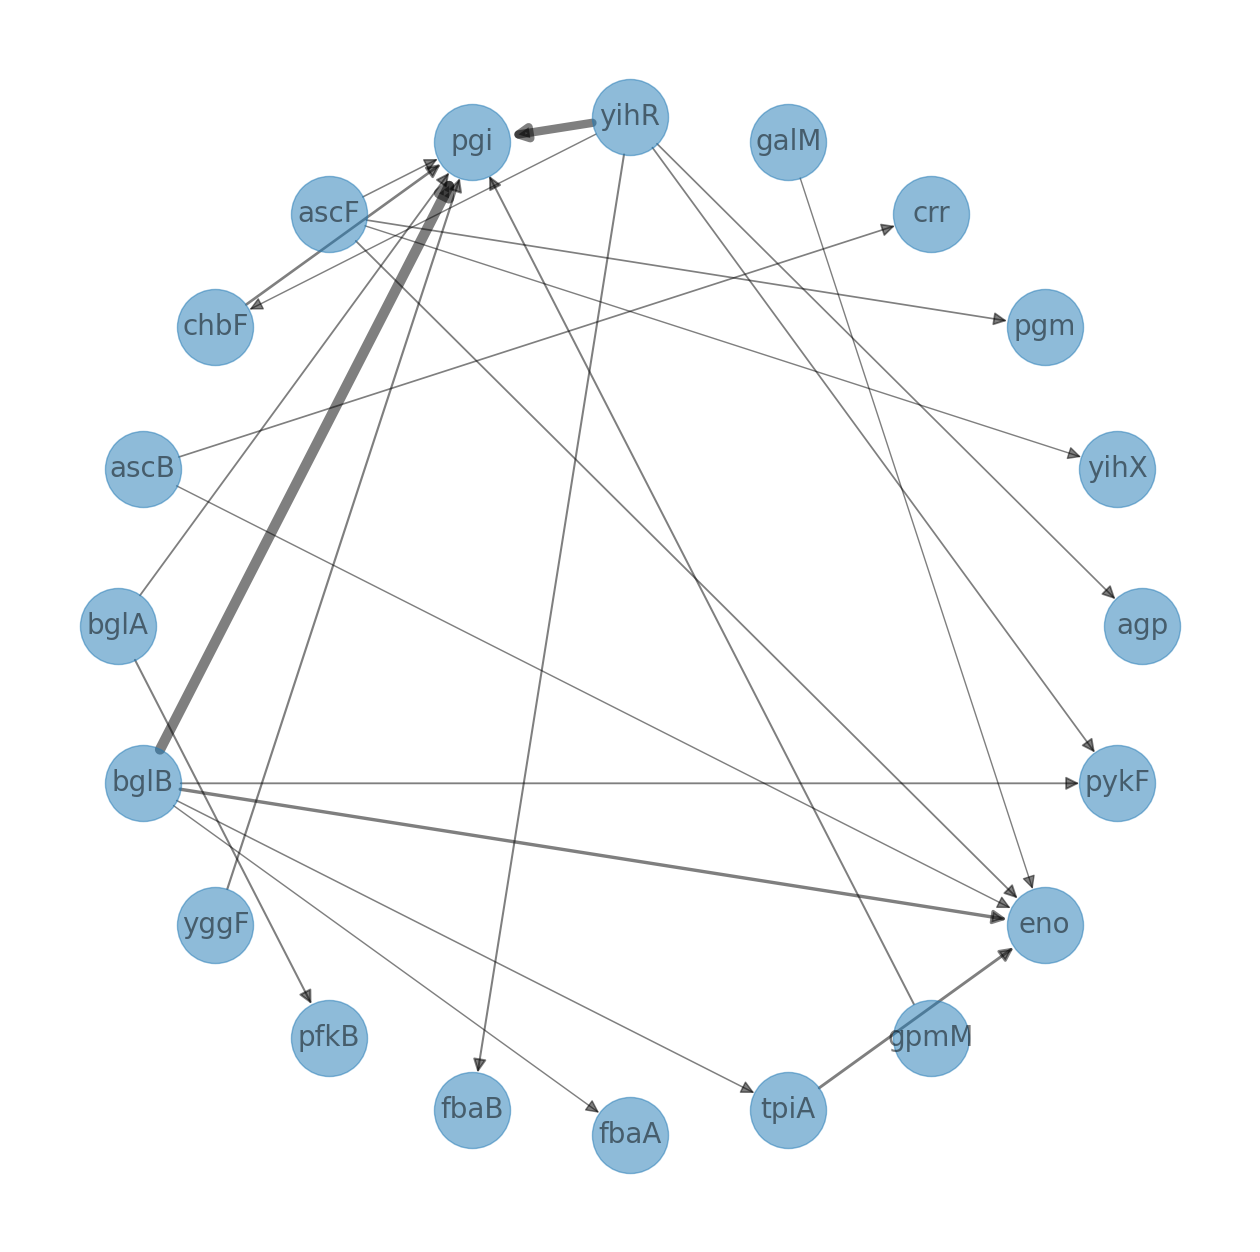

In [40]:
# ネットワーク図を描画
fig, ax = plt.subplots(figsize=(16,16))
nx.draw_circular(sm_l,
                 with_labels=True,
                 font_size=20,
                 node_size=3000,
                 arrowsize=20,
                 alpha=0.5,
                 width=edge_width,
                 ax=ax)

plt.savefig("./output/best_network.png", format="png", dpi=300)

# ベイジアンネットワーク

## 離散化処理

In [60]:
# Discretize the features
# Excluding the first column which seems to be an index or identifier
discretizer = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
discretised_data = discretizer.fit_transform(normalized_df.iloc[:, :])

# Creating a new DataFrame for the discretized data
discretised_data = pd.DataFrame(discretised_data, columns=normalized_df.columns)

# Display the first few rows of the discretized data
discretised_data.head()

,glk,agp,yihX,pgm,ptsG,malx,crr,galM,yihR,yeaD,...,tpiA,gapA,pgk,gpmA,ytjc,gpmM,eno,pykF,pykA,ppsA
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [85]:
# 構造モデルのノードの確認
print('sm_l.nodes:', sm_l.nodes)
nodes = ['agp', 'yihX', 'pgm', 'crr', 'galM', 'yihR', 'pgi', 'ascF', 'chbF', 'ascB', 'bglA', 'bglB', 'yggF', 'pfkB', 'fbaB', 'fbaA', 'tpiA', 'gpmM', 'eno', 'pykF']
print('nodes:', nodes)

sm_l.nodes: ['agp', 'yihX', 'pgm', 'crr', 'galM', 'yihR', 'pgi', 'ascF', 'chbF', 'ascB', 'bglA', 'bglB', 'yggF', 'pfkB', 'fbaB', 'fbaA', 'tpiA', 'gpmM', 'eno', 'pykF']
nodes: ['agp', 'yihX', 'pgm', 'crr', 'galM', 'yihR', 'pgi', 'ascF', 'chbF', 'ascB', 'bglA', 'bglB', 'yggF', 'pfkB', 'fbaB', 'fbaA', 'tpiA', 'gpmM', 'eno', 'pykF']


In [86]:
bn = BayesianNetwork(sm_l)
train, test = train_test_split(discretised_data, train_size=0.9, test_size=0.1)
bn = bn.fit_node_states(discretised_data)
bn = bn.fit_cpds(train)

In [91]:
for i in range(len(nodes)):
    print(nodes[i])
    display(bn.cpds[nodes[i]])

agp


yihR,0.0,2.0
agp,,
0.0,1.0,0.0
2.0,0.0,1.0


yihX


ascF,0.0,2.0
yihX,,
0.0,0.988235,0.0
1.0,0.011765,0.0
2.0,0.000000,1.0


pgm


ascF,0.0,2.0
pgm,,
0.0,0.988235,0.0
1.0,0.011765,0.0
2.0,0.000000,1.0


crr


ascB,0.0,2.0
crr,,
0.0,1.0,0.5
2.0,0.0,0.5


galM


,
galM,
0.0,0.994152
2.0,0.005848


yihR


,
yihR,
0.0,0.994152
2.0,0.005848


pgi


ascF       0.0                                               ...  2.0       \
bglA       0.0                                               ...  2.0        
bglB       0.0                                               ...  2.0        
chbF       0.0                                     2.0       ...  0.0        
gpmM       0.0                 2.0                 0.0       ...  2.0        
yggF       0.0       2.0       0.0       2.0       0.0       ...  2.0        
yihR       0.0  2.0  0.0  2.0  0.0  2.0  0.0  2.0  0.0  2.0  ...  0.0  2.0   
pgi                                                          ...             
0.0   0.994118  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  ...  0.5  0.5   
2.0   0.005882  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  ...  0.5  0.5   

ascF                                          
bglA                                          
bglB                                          
chbF  2.0                                     
gpmM  0.0                 2.0                 
yggF  0.0       2.0       0.0       2.0       
yihR  0.0  2.0  0.0  2.0  0.0  2.0  0.0  2.0  
pgi                                           
0.0   0.5  0.5  0.5  0.5  0.5  0.5  0.5  1.0  
2.0   0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.0  

[2 rows x 128 columns]

ascF


,
ascF,
0.0,0.994152
2.0,0.005848


chbF


yihR,0.0,2.0
chbF,,
0.0,1.0,0.0
2.0,0.0,1.0


ascB


,
ascB,
0.0,0.988304
2.0,0.011696


bglA


,
bglA,
0.0,0.994152
2.0,0.005848


bglB


,
bglB,
0.0,0.994152
2.0,0.005848


yggF


,
yggF,
0.0,0.994152
2.0,0.005848


pfkB


bglA,0.0,2.0
pfkB,,
0.0,0.982353,0.0
1.0,0.017647,0.0
2.0,0.000000,1.0


fbaB


yihR,0.0,2.0
fbaB,,
0.0,0.629412,0.0
1.0,0.335294,0.0
2.0,0.035294,1.0


fbaA


bglB,0.0,2.0
fbaA,,
0.0,0.976471,0.0
1.0,0.023529,0.0
2.0,0.000000,1.0


tpiA


bglB,0.0,2.0
tpiA,,
0.0,0.994118,0.0
1.0,0.005882,0.0
2.0,0.000000,1.0


gpmM


,
gpmM,
0.0,0.994152
2.0,0.005848


eno


ascB       0.0                                                         \
ascF       0.0                                                          
bglB       0.0                                                    2.0   
galM       0.0                      2.0                           0.0   
tpiA       0.0  1.0       2.0       0.0       1.0       2.0       0.0   
eno                                                                     
0.0   0.994048  1.0  0.333333  0.333333  0.333333  0.333333  0.333333   
1.0   0.005952  0.0  0.333333  0.333333  0.333333  0.333333  0.333333   
2.0   0.000000  0.0  0.333333  0.333333  0.333333  0.333333  0.333333   

ascB                                ...       2.0                      \
ascF                                ...       2.0                       
bglB                                ...       0.0                       
galM                           2.0  ...       0.0       2.0             
tpiA       1.0       2.0       0.0  ...       2.0       0.0       1.0   
eno                                 ...                                 
0.0   0.333333  0.333333  0.333333  ...  0.333333  0.333333  0.333333   
1.0   0.333333  0.333333  0.333333  ...  0.333333  0.333333  0.333333   
2.0   0.333333  0.333333  0.333333  ...  0.333333  0.333333  0.333333   

ascB                                                                   
ascF                                                                   
bglB                 2.0                                               
galM                 0.0                           2.0                 
tpiA       2.0       0.0       1.0       2.0       0.0       1.0  2.0  
eno                                                                    
0.0   0.333333  0.333333  0.333333  0.333333  0.333333  0.333333  1.0  
1.0   0.333333  0.333333  0.333333  0.333333  0.333333  0.333333  0.0  
2.0   0.333333  0.333333  0.333333  0.333333  0.333333  0.333333  0.0  

[3 rows x 48 columns]

pykF


bglB       0.0                 2.0     
yihR       0.0       2.0       0.0  2.0
pykF                                   
0.0   0.988235  0.333333  0.333333  0.0
1.0   0.011765  0.333333  0.333333  0.0
2.0   0.000000  0.333333  0.333333  1.0

# 評価

In [93]:
predictions = bn.predict(discretised_data, "pgi")
print(discretised_data.loc[1, "pgi"])

0.0


In [94]:
display(classification_report(bn, test, "pgi"))

{'pgi_0.0': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 20.0},
 'pgi_2.0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0.0},
 'micro avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 20.0},
 'macro avg': {'precision': 0.5,
  'recall': 0.5,
  'f1-score': 0.5,
  'support': 20.0},
 'weighted avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 20.0}}

In [95]:
for n in bn.nodes:
    roc, auc = roc_auc(bn, test, n)
    print(n, auc)

galM 1.0
eno 0.95
yihR 1.0
agp 1.0
pgi 1.0
chbF 1.0
fbaB 0.7249999999999999
pykF 1.0
ascF 1.0
yihX 1.0
pgm 1.0
ascB 1.0
crr 1.0
bglA 1.0
pfkB 1.0
bglB 1.0
fbaA 0.975
tpiA 1.0
yggF 1.0
gpmM 1.0
